<a href="https://colab.research.google.com/github/MerveNazlim/CatNN/blob/main/signalNN_vll_clean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install mplhep

     |████████████████████████████████| 11.2 MB 7.7 MB/s 
     |████████████████████████████████| 5.8 MB 16.2 MB/s 
     |████████████████████████████████| 895 kB 52.7 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
!pip install tensorflow==2.4.1

     |████████████████████████████████| 394.3 MB 10 kB/s 
     |████████████████████████████████| 3.8 MB 23.3 MB/s 
     |████████████████████████████████| 2.9 MB 9.0 MB/s 
     |████████████████████████████████| 132 kB 45.9 MB/s 
     |████████████████████████████████| 462 kB 46.5 MB/s 
  Created wheel for wrapt: filename=wrapt-1.12.1-cp37-cp37m-linux_x86_64.whl size=68720 sha256=d88b99a3730681acff861f269a5b68f12436c5d95dbc892f95347dd56b53d573
  Stored in directory: /root/.cache/pip/wheels/62/76/4c/aa25851149f3f6d9785f6c869387ad82b3fd37582fa8147ac6
Successfully built wrapt
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 3.10.0.2
    Uninstalling typing-extensions-3.10.0.2:
      Successfully uninstalled typing-extensions-3.10.0.2
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.43.0
    Uninstalling grpcio-1.43.0:
      Successfully uninstalled grpcio-1.43.0
  Attempting uninstall: absl-py
    Found existing installa

In [ ]:
!pip install h5py==2.10.0

In [ ]:
!pip install matplotlib==3.2.2

     |████████████████████████████████| 12.4 MB 4.4 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.1
    Uninstalling matplotlib-3.5.1:
      Successfully uninstalled matplotlib-3.5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mplhep 0.3.20 requires matplotlib>=3.4, but you have matplotlib 3.2.2 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
cp gdrive/MyDrive/VLL_h5/vll2lOS_signals_2lcat3.h5 .

In [ ]:
#!/usr/bin/env python

import argparse
import sys
import os
from time import time
#from preprocess import mkdir_p, unique_filename
import pickle
import math

# h5py
import h5py
import tensorflow as tf
tf.random.set_seed(400)
from tensorflow import keras
# keras
#from tensorflow.keras.models import Model
#from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras import models as Km
from tensorflow.keras import layers as Kl
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import regularizers
from tensorflow.keras import initializers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
import tensorflow.keras
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_auc_score,roc_curve, auc
from sklearn.preprocessing import scale, normalize
from sklearn.preprocessing import RobustScaler, StandardScaler,minmax_scale,MinMaxScaler,MaxAbsScaler
from sklearn.model_selection import KFold, StratifiedKFold,GroupKFold

import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.losses import binary_crossentropy, categorical_crossentropy
from functools import partial
from tensorflow.keras import initializers
import numpy as np
seed = 400
np.random.seed(seed)
#import mplhep as hep


In [ ]:
tf.keras.backend.clear_session()


In [ ]:
def mkdir_p(path) :

    import errno

    """
    Make a directory, if it exists silence the exception

    Args:
        path : full directory path to be made
    """

    try :
        os.makedirs(path)
    except OSError as exc :
        if exc.errno == errno.EEXIST and os.path.isdir(path) :
            pass
        else :
            raise

In [ ]:
#define the folder name
path_tosave = 'gdrive/MyDrive/vll_2LOS_cat3_lessvariable2methtjetsmtlep'
mkdir_p(path_tosave)

In [ ]:
class Sample :

    """
    Sample

    This class will hold the feature data for a given sample.
    """

    def __init__(self, name = "", class_label = -1, input_data = None) :
        """
        Sample constructor

        Args :
            name : descriptive name of the sample (obtained from the input
                pre-processed file)
            input_data : numpy array of the data from the pre-processed file
                (expects an array of dtype = np.float64, not a structured array!)
            class_label : input class label as found in the input pre-processed
                file
        """

        if input_data.dtype != np.float64 :
            raise Exception("ERROR Sample input data must be type 'np.float64', input is '{}'".format(input_data.dtype))

        if class_label < 0 :
            raise ValueError("ERROR Sample (={})class label is not set (<0)".format(name, class_label))

        print("Creating sample {} (label = {})".format(name, class_label))

        self._name = name
        self._class_label = class_label
        self._input_data = input_data
        self._regression_inputs = None

    def name(self) :
        return self._name
    def class_label(self) :
        return self._class_label
    def data(self) :
        return self._input_data
    @property
    def regression_inputs(self) :
        return self._regression_inputs
    @regression_inputs.setter
    def regression_inputs(self, data) :
        self._regression_inputs = data
        


class DataScaler :

    """
    DataScaler

    This class will hold the scaling information needed for the training
    features (variables) contained in the input, pre-processed file.
    Its constructor takes as input the scaling data dataset object
    contained in the pre-processed file and it builds the associated
    feature-list and an associated dictionary to store the scaling
    parameters for each of the input features.
    """

    def __init__(self, scaling_dataset = None, ignore_features = []) :

        """
        ScalingData constructor

        Args:
            scaling_dataset : input HDF5 dataset object which contains the
                scaling data and feature-list
        """

        self._raw_feature_list = []
        self._feature_list = []
        self._scaling_dict = {}
        self._mean = []
        self._scale = []
        self._var = []
        self.load(scaling_dataset, ignore_features)

    def load(self, scaling_dataset = None, ignore_features = []) :

        self._raw_feature_list = list( scaling_dataset['name'] )
        self._feature_list = list( filter( lambda x : x not in ignore_features, self._raw_feature_list ) )

        #self._mean = scaling_dataset['mean']
        #self._scale = scaling_dataset['scale']
        #self._var = scaling_dataset['var']


        for x in scaling_dataset :
            name, mean, scale, var = x['name'], x['mean'], x['scale'], x['var']
            if name in ignore_features : continue
            self._scaling_dict[name] = { 'mean' : mean, 'scale' : scale, 'var' : var }
            self._mean.append(mean)
            self._scale.append(scale)
            self._var.append(var)

        self._mean = np.array(self._mean, dtype = np.float64)
        self._scale = np.array(self._scale, dtype = np.float64)
        self._var = np.array(self._var, dtype = np.float64)

    def raw_feature_list(self) :
        return self._raw_feature_list

    def feature_list(self) :
        return self._feature_list

    def scaling_dict(self) :
        return self._scaling_dict

    def get_params(self, feature = "") :
        if feature in self._scaling_dict :
            return self._scaling_dict[feature]
        raise KeyError("requested feature (={}) not found in set of scaling features".format(feature))

    def mean(self) :
        return self._mean
    def scale(self) :
        return self._scale
    def var(self) :
        return self._var

def floatify(input_array, feature_list) :
    ftype = [(name, float) for name in feature_list]
    return input_array.astype(ftype).view(float).reshape(input_array.shape + (-1,))

def load_input_file(args) :

    """
    Check that the provided input HDF5 file is of the expected form
    as defined by the pre-processing. Exits if this is not the case.
    Returns a list of the sample names found in the file.

    Args :
        args : user input to the executable
    """

    # check that the file can be found
    if not os.path.isfile(args) :
        print("ERROR provided input file (={}) is not found or is not a regular file".format(args))
        sys.exit()

    samples_group_name = "samples"
    scaling_group_name = "scaling"
    scaling_data_name = "scaling_data"

    found_samples = False
    found_scalings = False
    samples = []
    data_scaler = None
    features_to_ignore = ["xs","total_charge","DeltaR_min_lep_bjet77","DeltaR_max_lep_bjet77","jet_pt0_nofwd","MtLepMet","HT_lep"]
    #features_to_ignore = ["eventweight", "eventNumber"]

    with h5py.File(args, 'r') as input_file :

        # look up the scalings first, in order to build the feature list used for the Sample creation
        if scaling_group_name in input_file :
            found_scalings = True
            scaling_group = input_file[scaling_group_name]
            scaling_dataset = scaling_group[scaling_data_name]
            data_scaler = DataScaler( scaling_dataset = scaling_dataset, ignore_features = features_to_ignore )
            print("DataScaler found {} features to train on (there were {} total features in the input)".format( len(data_scaler.feature_list()), len(data_scaler.raw_feature_list() )))
        else :
            print("scaling group (={}) not found in file".format(scaling_group_name))
            sys.exit()

        # now build the samples
        if samples_group_name in input_file :
            found_samples = True
            sample_group = input_file[samples_group_name]
            for p in sample_group :
                process_group = sample_group[p]
                class_label = process_group.attrs['training_label']
                s = Sample(name = p, class_label = int(class_label),
                    input_data = floatify( process_group['train_features'][tuple(data_scaler.feature_list())], data_scaler.feature_list() ) )
                #print(floatify( process_group['train_features'][tuple(data_scaler.feature_list())], data_scaler.feature_list() ))
                samples.append(s)

        else :
            print("samples group (={}) not found in file".format(samples_group_name))
            sys.exit()

    samples = sorted(samples, key = lambda x: x.class_label())

    return samples, data_scaler

def load_input_file_val(args) :

    if not os.path.isfile(args) :
        print("ERROR provided input file (={}) is not found or is not a regular file".format(args))
        sys.exit()

    samples_group_name = "samples"
    scaling_group_name = "scaling"
    scaling_data_name = "scaling_data"

    samples = []
    data_scaler = None
    features_to_ignore = ["xs","total_charge","DeltaR_min_lep_bjet77","DeltaR_max_lep_bjet77","HT_jets","jet_pt0_nofwd","HT_lep"]

    with h5py.File(args, 'r', libver = 'latest') as input_file :

        # look up the scaling first
        if scaling_group_name in input_file :
            scaling_group = input_file[scaling_group_name]
            scaling_dataset = scaling_group[scaling_data_name]
            data_scaler = DataScaler( scaling_dataset = scaling_dataset, ignore_features = features_to_ignore )
            print("DataScaler found {} features to use as inputs (there were {} total features in the input)".format( len(data_scaler.feature_list()), len(data_scaler.raw_feature_list())))
        else :
            print("scaling group (={}) not found in file".format(scaling_group_name))
            sys.exit()

        # build the samples
        if samples_group_name in input_file :
            sample_group = input_file[samples_group_name]
            for p in sample_group :
                process_group = sample_group[p]
                class_label = process_group.attrs['training_label']
                s = Sample(name = p, class_label = int(class_label),
                    input_data = floatify( process_group['validation_features'][tuple(data_scaler.feature_list())], data_scaler.feature_list()))
                samples.append(s)
        else :
            print("samples group (={}) not found in file".format(samples_group_name))
            sys.exit()

    return samples, data_scaler

def build_combined_input(training_samples, data_scaler = None, scale = True) :

    targets = []
    # used extended slicing to partition arbitrary number of samples
    sample0, sample1, *other = training_samples

    targets.extend( np.ones( sample0.data().shape[0] ) * sample0.class_label() )
    targets.extend( np.ones( sample1.data().shape[0] ) * sample1.class_label() )

    inputs = np.concatenate( (sample0.data(), sample1.data()), axis = 0)
    for sample in other :
        inputs = np.concatenate( (inputs, sample.data()) , axis = 0 )
        targets.extend( np.ones( sample.data().shape[0] ) * sample.class_label() )

    # perform scaling
    input_notscale = inputs
    if scale :
        inputs = (inputs - data_scaler.mean()) / data_scaler.scale()
        #print(inputs)

    targets = np.array(targets, dtype = int )


    return inputs, targets, input_notscale


In [ ]:
def sample_with_label(label, samples) :

    for s in samples :
        if s.class_label() == label :
            return s
    return None
def make_nn_roc_curve( path_tosave, output_scores = None, samples = [], inputs = None, targets = None, signal_class = 0) :
    class_labels = set(targets)
    targets_list = list(targets)
    nn_scores_dict = {}
    signal_class=0
    names = {}
    for sample in validation_samples :
        names[sample.class_label()] = sample.name()

    for ilabel, label in enumerate(class_labels) :
        left = targets_list.index(label)
        right = len(targets_list) - 1 - targets_list[::-1].index(label)
        nn_scores_dict[label] = output_scores[left:right+1]
        print(nn_scores_dict)
        
    lowbin = 0
    highbin = 1


    edges = np.concatenate([[-np.inf], np.linspace(lowbin,highbin,500), [np.inf]]) 
    sample_eff = {}
    h_total = []
    w_total = []
    for label in nn_scores_dict :
        # select out the scores for class 'label' for NN output 'signal_class'
        scores = nn_scores_dict[label][:,signal_class]
        print(scores)
        #weights = sample_with_label(label, samples).eventweights
        h_nn, _ = np.histogram( scores, bins = edges )
        if label != signal_class :
            h_total.append(h_nn)
        eff = np.cumsum( h_nn[::-1] )[::-1] / h_nn.sum()
        sample_eff[label] = eff
    
    summed_bkg = h_total[0]
    for h in h_total[1:] :
        summed_bkg += h
    #summed_weights = w_total[0]
    #for h in w_total[1:] :
    #    summed_weights += h
    eff_total_bkg = np.cumsum( summed_bkg[::-1] )[::-1]/summed_bkg.sum()

    signal_eff = None
    bkg_eff = {}
    for e in sample_eff :
        if e == signal_class :
            signal_eff = sample_eff[e]
        else :
            bkg_eff[e] = sample_eff[e]


    fig, ax = plt.subplots(1,1)
    for bkg_label in bkg_eff :
    
        bkg = bkg_eff[bkg_label]
        valid_rej = bkg > 0
        sig = np.array(signal_eff[:])

        valid_sig = (sig != 1.0)
        valid = valid_rej & valid_sig

        bkg = bkg[valid]
        sig = sig[valid]

        bkg_rej = 1/bkg
        ax.plot(sig, bkg_rej, label = names[bkg_label])

    valid_rej_total = eff_total_bkg > 0
    sig = np.array(signal_eff[:])
    valid_sig_total = sig != 1.0
    valid_total = valid_rej_total & valid_sig_total

    bkg_total = eff_total_bkg[valid_total]
    sig_total = sig[valid_total]
    bkg_rej_total = 1/bkg_total
    ax.plot(sig_total, bkg_rej_total, label = "Total Bkg")

    ax.set_yscale('log')
    ax.set_xlabel('signal efficiency', horizontalalignment='right', x=1)
    ax.set_ylabel('Background rejection, $1/\\epsilon_{bkg}$', horizontalalignment='right', y=1)
    ax.legend(loc='best', frameon = False)

    # save
    savename = "nn_output_ROC_{}.pdf".format(path_tosave)
    #if args.outdir != "" :
    #    mkdir_p(args.outdir)
    savename = "{}/{}".format(path_tosave, savename)
    fig.savefig(savename, bbox_inches = 'tight', dpi = 200)

In [ ]:
def sample_with_label(label, samples) :

    for s in samples :
        if s.class_label() == label :
            return s
    return None
def make_nn_roc_curve( path_tosave, output_scores = None, samples = [], inputs = None, targets = None, signal_class = 0) :
    class_labels = set(targets)
    targets_list = list(targets)
    nn_scores_dict = {}
    signal_class=0
    names = {}
    for sample in validation_samples :
        names[sample.class_label()] = sample.name()

    for ilabel, label in enumerate(class_labels) :
        left = targets_list.index(label)
        right = len(targets_list) - 1 - targets_list[::-1].index(label)
        nn_scores_dict[label] = output_scores[left:right+1]
        print(nn_scores_dict)
        
    lowbin = 0
    highbin = 1


    edges = np.concatenate([[-np.inf], np.linspace(lowbin,highbin,500), [np.inf]]) 
    sample_eff = {}
    h_total = []
    w_total = []
    for label in nn_scores_dict :
        # select out the scores for class 'label' for NN output 'signal_class'
        scores = nn_scores_dict[label][:,signal_class]
        print(scores)
        #weights = sample_with_label(label, samples).eventweights
        h_nn, _ = np.histogram( scores, bins = edges )
        if label != signal_class :
            h_total.append(h_nn)
        eff = np.cumsum( h_nn[::-1] )[::-1] / h_nn.sum()
        sample_eff[label] = eff
    
    summed_bkg = h_total[0]
    for h in h_total[1:] :
        summed_bkg += h
    #summed_weights = w_total[0]
    #for h in w_total[1:] :
    #    summed_weights += h
    eff_total_bkg = np.cumsum( summed_bkg[::-1] )[::-1]/summed_bkg.sum()

    signal_eff = None
    bkg_eff = {}
    for e in sample_eff :
        if e == signal_class :
            signal_eff = sample_eff[e]
        else :
            bkg_eff[e] = sample_eff[e]


    fig, ax = plt.subplots(1,1)
    for bkg_label in bkg_eff :
    
        bkg = bkg_eff[bkg_label]
        valid_rej = bkg > 0
        sig = np.array(signal_eff[:])

        valid_sig = (sig != 1.0)
        valid = valid_rej & valid_sig

        bkg = bkg[valid]
        sig = sig[valid]

        bkg_rej = 1/bkg
        ax.plot(sig, bkg_rej, label = names[bkg_label])

    valid_rej_total = eff_total_bkg > 0
    sig = np.array(signal_eff[:])
    valid_sig_total = sig != 1.0
    valid_total = valid_rej_total & valid_sig_total

    bkg_total = eff_total_bkg[valid_total]
    sig_total = sig[valid_total]
    bkg_rej_total = 1/bkg_total
    ax.plot(sig_total, bkg_rej_total, label = "Total Bkg")

    ax.set_yscale('log')
    ax.set_xlabel('$hh$ efficiency', horizontalalignment='right', x=1)
    ax.set_ylabel('Background rejection, $1/\\epsilon_{bkg}$', horizontalalignment='right', y=1)
    ax.legend(loc='best', frameon = False)

    # save
   # savename = "nn_output_ROC_{}.pdf".format(path_tosave)
    #if args.outdir != "" :
    #    mkdir_p(args.outdir)
    savename = "{}/{}".format(path_tosave, savename)
    fig.savefig(savename, bbox_inches = 'tight', dpi = 200)

In [ ]:
def make_nn_output_plots_tekcift( path_tosave, model = None, inputs = None, samples = None, targets = None, events=None) :

    # set of scores for each label: shape = (n_samples, n_outputs)
    # inputs_tek=inputs[1::2]
    # inputs_cift=inputs[::2]
    inputs_tek = inputs[events % 2==1]
    inputs_cift = inputs[events % 2==0]
    # evtnum % 2 == 0
    nn_scores = np.ones([targets.size,len(training_samples)])
    #nn_scores = model.predict(inputs,verbose = True)
    nn_scores_tek = model[0].predict(inputs_tek,verbose = True)
    nn_scores_cift = model[1].predict(inputs_cift,verbose = True)
    nn_scores[events % 2==1] = nn_scores_tek
    nn_scores[events % 2==0] = nn_scores_cift
    class_labels = set(targets)
    targets_list = list(targets)
    nn_scores_dict = {}

    # index the sample names by their class label
    names = {}
    for sample in samples :
        names[sample.class_label()] = sample.name()

    # break up the predicted scores by the class label
    for ilabel, label in enumerate(class_labels) :
        # left-most appearance of the label
        left = targets_list.index(label)
        # right-most appearance of the label
        right = len(targets_list) - 1 - targets_list[::-1].index(label)
        nn_scores_dict[label] = nn_scores[left:right+1]

    # start plotting
    for label in class_labels :
        #fig, ax = plt.subplots(1,1)
        fig = plt.figure()
        plt.grid(color='k', which='both', linestyle='--', lw=0.5, alpha=0.1, zorder = 0)
        plt.xlabel( "NN output for label {}".format(names[label]), horizontalalignment='right', x=1)
        #ax.set_xlim([1e-2,1.0])
        plt.xlim([0,1])
        plt.yscale('log')
        histargs = {"bins":20, "range":(0,1.), "density":True, "histtype":'step'}
        #binning = np.arange(0,1,0.02)
        #centers = (binning[1:-2] + binning[2:-1])/2
        #ax.set_xlim((centers[0]-0.1, centers[-1]+0.1)) 
        for sample_label in nn_scores_dict :
            sample_scores_for_label = nn_scores_dict[sample_label][:,label]
            print(sample_scores_for_label)
            #sample_weights = sample_with_label(sample_label, samples).eventweights

            #yields, _ = np.histogram(sample_scores_for_label, bins = binning)
            plt.hist(sample_scores_for_label,label = names[sample_label], **histargs)
            #yields = yields/yields.sum()
            #ax.step(centers, yields[1:-1], label = names[sample_label], where = 'mid')
            
            #ax.hist(sample_scores_for_label, bins = binning, alpha = 0.3, label = names[sample_label], density = True)
        plt.legend(loc='best', frameon = False)
        
        savename = "nn_outputs_class_{}.pdf".format( names[label])

        savename = "{}/{}".format(path_tosave, savename) 
        plt.savefig(savename, bbox_inches = 'tight', dpi = 200)

    return nn_scores

In [ ]:
def make_nn_output_plots( path_tosave, model = None, inputs = None, samples = None, targets = None) :

    # set of scores for each label: shape = (n_samples, n_outputs)
    nn_scores = model.predict(inputs,verbose = True)

    class_labels = set(targets)
    targets_list = list(targets)
    nn_scores_dict = {}

    # index the sample names by their class label
    names = {}
    for sample in samples :
        names[sample.class_label()] = sample.name()

    # break up the predicted scores by the class label
    for ilabel, label in enumerate(class_labels) :
        # left-most appearance of the label
        left = targets_list.index(label)
        # right-most appearance of the label
        right = len(targets_list) - 1 - targets_list[::-1].index(label)
        nn_scores_dict[label] = nn_scores[left:right+1]

    # start plotting
    for label in class_labels :
        #fig, ax = plt.subplots(1,1)
        fig = plt.figure()
        plt.grid(color='k', which='both', linestyle='--', lw=0.5, alpha=0.1, zorder = 0)
        plt.xlabel( "NN output for label {}".format(names[label]), horizontalalignment='right', x=1)
        #ax.set_xlim([1e-2,1.0])
        plt.xlim([0,1])
        plt.yscale('log')
        histargs = {"bins":20, "range":(0,1.), "density":True, "histtype":'step'}
        #binning = np.arange(0,1,0.02)
        #centers = (binning[1:-2] + binning[2:-1])/2
        #ax.set_xlim((centers[0]-0.1, centers[-1]+0.1)) 
        for sample_label in nn_scores_dict :
            sample_scores_for_label = nn_scores_dict[sample_label][:,label]
            print(sample_scores_for_label)
            #sample_weights = sample_with_label(sample_label, samples).eventweights

            #yields, _ = np.histogram(sample_scores_for_label, bins = binning)
            plt.hist(sample_scores_for_label,label = names[sample_label], **histargs)
            #yields = yields/yields.sum()
            #ax.step(centers, yields[1:-1], label = names[sample_label], where = 'mid')
            
            #ax.hist(sample_scores_for_label, bins = binning, alpha = 0.3, label = names[sample_label], density = True)
        plt.legend(loc='best', frameon = False)
        
        savename = "nn_outputs_class_{}.pdf".format( names[label])

        savename = "{}/{}".format(path_tosave, savename) 
        plt.savefig(savename, bbox_inches = 'tight', dpi = 200)

    return nn_scores

In [ ]:
class roc_callback(Callback) :
    def on_train_begin(self, logs = {}) :
        self.val_aucs = []
        self.val_losses = []

    def on_train_end(self, logs = {}) :
        return

    def on_epoch_begin(self, epoch, logs = {}) :
        return

    def on_epoch_end(self, epoch, logs = {}) :

        self.val_losses.append(logs.get('val_loss'))

        y_pred = self.model.predict(self.validation_data[0])
        y_true = self.validation_data[1]
        val_auc = roc_auc_score(y_true, y_pred)
        print('val_roc_auc = %s' % ( str(round(val_auc,4)) ))
        self.val_aucs.append(val_auc)
        logs['val_roc_auc'] = self.val_aucs

        return

    def on_batch_begin(self, batch, logs = {}) :
        return

def lr_step_decay(epoch) :

    initial_lr = 0.5
    drop = 0.9
    epoch_to_drop = 3

    if epoch >= 50 :
        epoch == 50
    elif epoch >= 25 :
        epoch -= 25
        print('INFO Setting learning rate back to initial LR (={})'.format(initial_lr))

    new_lr = initial_lr * math.pow(drop, math.floor((1+epoch)/epoch_to_drop))
    print('INFO LR Schedule: {}'.format(new_lr))
    return new_lr

In [ ]:
file = "vll2lOS_signals_2lcat3.h5"

In [ ]:
#read input pre-processed file for training
training_samples, data_scaler = load_input_file(file)

DataScaler found 8 features to train on (there were 13 total features in the input)
Creating sample HH (label = 0)
Creating sample HV (label = 1)
Creating sample VV (label = 2)


In [ ]:
input_features, targets, inp_nonsc= build_combined_input(training_samples, data_scaler = data_scaler, scale = True)

In [2]:
#event weights if exists
weights=inp_nonsc[:,-1]
weights[targets==1]
inp_nonsc=inp_nonsc[:,0:-1]#14

NameError: ignored

In [ ]:
#event numbers 
evtnum = inp_nonsc[:,-1]
inp_nonsc = inp_nonsc[:,0:-1]

In [1]:
#DSIDs 
mass = inp_nonsc[:,-1]
inp_nonsc = inp_nonsc[:,0:-1]

NameError: ignored

In [ ]:
#remove negative weights
targets = targets[np.where((weights<1) &(weights>0))]
inp_nonsc = inp_nonsc[np.where((weights<1) &(weights>0))]
evtnum =evtnum[np.where((weights<1) &(weights>0))]

In [ ]:
#3L for sum of DR
sum_dr= inp_nonsc[:,1]+inp_nonsc[:,2]+inp_nonsc[:,3]
asd=sum_dr.reshape(len(sum_dr),1)
asd2 = np.append(inp_nonsc,asd,axis=1)


In [ ]:
inp_nonsc=asd2[:,[0,4,5,6,7,8,9,10,11,12,13,14,15,16]]

In [ ]:
from collections import Counter
counter = Counter(targets)
print(counter)


Counter({2: 194896, 1: 176461, 0: 18435})


In [ ]:
#class reweighting 
weight_for_0 = (1 / 18435)*(389792)/2.0 
weight_for_1 = (1 / 176461)*(389792)/2.0
weight_for_2 = (1 / 194896)*(389792)/2.0

# weight_for_3 = (1 / 32959)*(389792)/2.0 
# weight_for_4 = (1 / 48082)*(389792)/2.0
# weight_for_5 = (1 / 2088)*(389792)/2.0

# class_weight = {0: weight_for_0, 1: weight_for_1, 2:weight_for_2, 3: weight_for_3, 4: weight_for_4, 5:weight_for_5}
class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2}
print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))
print('Weight for class 2: {:.2f}'.format(weight_for_2))

# print('Weight for class 3: {:.2f}'.format(weight_for_3))
# print('Weight for class 4: {:.2f}'.format(weight_for_4))
# print('Weight for class 5: {:.2f}'.format(weight_for_5))

Weight for class 0: 10.57
Weight for class 1: 1.10
Weight for class 2: 1.00


In [ ]:
# # n_per_sample = int(input_features.shape[0] / n_classes)
# randomize = np.arange(len(inp_nonsc))
# np.random.shuffle(randomize)
# inp_nonsc = inp_nonsc[randomize]
# evtnum = evtnum[randomize]
# targets = targets[randomize]
# weights = weights[randomize]

In [ ]:
# inp_nonsc =np.where(inp_nonsc==-99, 0 , inp_nonsc)
# inp_nonsc =np.where(inp_nonsc==-9999, 0 , inp_nonsc)
# inp_nonsc =np.where(inp_nonsc==9999, 0 , inp_nonsc)

In [ ]:
#scale the input between 0-1
scaler = StandardScaler().fit(inp_nonsc)
print(inp_nonsc)
inp_nonsc = scaler.transform(inp_nonsc)
print(inp_nonsc)
#inp_nonsc.shape

[[3.00000000e+00 1.10000000e+01 4.15028906e+05 2.36407344e+05
  0.00000000e+00 0.00000000e+00]
 [2.00000000e+00 7.00000000e+00 1.99796234e+05 3.82410625e+05
  0.00000000e+00 1.00000000e+00]
 [4.00000000e+00 1.20000000e+01 6.17417625e+05 5.96502852e+04
  0.00000000e+00 1.00000000e+00]
 ...
 [3.00000000e+00 3.00000000e+00 1.73705875e+05 3.52407344e+04
  1.00000000e+00 0.00000000e+00]
 [3.00000000e+00 3.00000000e+00 1.67898500e+05 1.25279625e+05
  1.00000000e+00 0.00000000e+00]
 [3.00000000e+00 1.50000000e+01 2.24640312e+05 9.12427109e+04
  1.00000000e+00 0.00000000e+00]]
[[-0.38148219  1.25437271 -0.50121248  0.34403154 -1.37791939 -0.47293618]
 [-1.07597896  0.20998616 -0.98920508  0.80723829 -1.37791939  2.0605521 ]
 [ 0.31301459  1.51546935 -0.04234071 -0.21674396 -1.37791939  2.0605521 ]
 ...
 [-0.38148219 -0.8344004  -1.04835922 -0.29418516 -0.07932954 -0.47293618]
 [-0.38148219 -0.8344004  -1.06152616 -0.00852978 -0.07932954 -0.47293618]
 [-0.38148219  2.29875926 -0.93287662 -0.116

In [ ]:
#save the scaling 
import pickle
scalerfile = path_tosave + '/scaler_standard.bin'
pickle.dump(scaler, open(scalerfile, 'wb'))

In [ ]:
def exponential_decay_fn(epoch): 
  return 0.05 * 0.1**(epoch / 20)

In [ ]:
def lr_step_decay(epoch) : #initial_lr, drop, epoch_to_drop) :

    initial_lr = 0.01
    drop = 0.9
    epoch_to_drop = 3

    if epoch >= 50 :
        epoch == 50
    elif epoch >= 25 :
        epoch -= 25
#        new_lr = initial_lr
        print('INFO Setting learning rate back to initial LR (={})'.format(initial_lr))

    new_lr = initial_lr * math.pow(drop, math.floor((1+epoch)/epoch_to_drop))
    print('INFO LR Schedule: {}'.format(new_lr))
    return new_lr

In [ ]:
auc_scores = []
auc_targets = []
acc_per_fold = []
loss_per_fold = []
results = []
model_history = []
fitfull_history = []
callbacks = []

In [ ]:
 # training   
    def fit_func2(n_classes, input_features_scale, targets, n_epochs = 400, batch_size = 2000, num_folds = 10) :
        # Define the K-fold Cross Validator
        kfold = GroupKFold(n_splits=2)
       # kfold = StratifiedKFold(n_splits=2)
        # Define per-fold score containers
        acc_per_fold = []
        loss_per_fold = []
        number = int((targets.size)/2)
        #group = [0,1]*number
        group = asd=evtnum % 2 ==0
        targets_encoded = keras.utils.to_categorical(targets, num_classes = n_classes)
        # K-fold Cross Validation model evaluation
        fold_no = 1
        for train, test in kfold.split(input_features_scale, targets_encoded,group):
            print("TRAIN:", train, "TEST:", test)
            layer_opts = dict( activation = 'relu', kernel_initializer = tf.keras.initializers.TruncatedNormal(mean=0.0, stddev=0.05, seed=seed))
            input_layer = Kl.Input( name = "InputLayer", shape = (len(inp_nonsc[1]),) )
            x = Kl.Dense( 22, **layer_opts ) (input_layer)
            x = Kl.Dropout(0.2)(x)
            x = Kl.Dense( 22, **layer_opts ) (x)
            # x = Kl.Dropout(0.2)(x)
            predictions = Kl.Dense( n_classes, activation = 'softmax', name = "OutputLayer" )(x)
            model = Km.Model( inputs = input_layer, outputs = predictions )
            model_optimizer = Adam(lr=0.0002)
            model.compile( loss = 'categorical_crossentropy', optimizer = model_optimizer, metrics = ['categorical_accuracy',] ) 
            # Generate a print
            print('------------------------------------------------------------------------')
            print(f'Training for fold {fold_no} ...')
              # Fit data to model
            # w_train = weights[train]
            fit_history = model.fit(input_features_scale[train], targets_encoded[train],
              batch_size=batch_size,
              epochs=n_epochs, validation_data = (input_features_scale[test], targets_encoded[test]), class_weight=class_weight)
              # Generate generalization metrics
            scores = model.evaluate(input_features_scale[test], targets_encoded[test], verbose=0)
            nn_scores = model.predict(input_features_scale[test],verbose = True)
            print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
            acc_per_fold.append(scores[1] * 100)
            loss_per_fold.append(scores[0])
            results.append(scores)
            model_history.append(model)
            fitfull_history.append(fit_history)
            auc_scores.append(nn_scores)
            auc_targets.append(targets[test])

              # Increase fold number
            fold_no = fold_no + 1
        #fit_history = model1.fit(x_train, y_train, epochs = n_epochs, batch_size = batch_size, shuffle = True, validation_data = (x_val, y_val),callbacks=callback)

        #self._fit_history = self._model.fit(x_train, y_train, epochs = n_epochs, batch_size = batch_size, shuffle = True, validation_data = (x_val, y_val), callbacks = callbacks)
        return model_history, fitfull_history, results

In [ ]:
#run training
my_model_fin_func, fit_history_func, res = fit_func2( len(training_samples), inp_nonsc, targets, n_epochs = 100, batch_size = 2000, num_folds = 2)


TRAIN: [     3      6      8 ... 389788 389789 389791] TEST: [     0      1      2 ... 389786 389787 389790]
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
96/96 [==============================] - 3s 24ms/step - loss: 1.6362 - categorical_accuracy: 0.5068 - val_loss: 1.0793 - val_categorical_accuracy: 0.4834
Epoch 2/100
96/96 [==============================] - 1s 11ms/step - loss: 1.5863 - categorical_accuracy: 0.4821 - val_loss: 1.0238 - val_categorical_accuracy: 0.4797
Epoch 3/100
96/96 [==============================] - 1s 13ms/step - loss: 1.4488 - categorical_accuracy: 0.4820 - val_loss: 0.9508 - val_categorical_accuracy: 0.4943
Epoch 4/100
96/96 [==============================] - 1s 14ms/step - loss: 1.3593 - categorical_accuracy: 0.5006 - val_loss: 0.9169 - val_categorical_accuracy: 0.5059
Epoch 5/100
96/96 [==============================] - 1s 12ms/step - loss: 1.3219 - categorical_accuracy: 0.5114 - val_loss: 0.9029

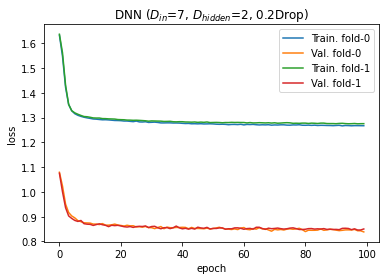

In [ ]:
#plot loss
for x in range(0,2):
    plt.plot(fit_history_func[x].history['loss'], label='Train. fold-'+str(x))
    plt.plot(fit_history_func[x].history['val_loss'], label='Val. fold-'+str(x))
    plt.title('DNN ($D_{in}$=7, $D_{hidden}$=2, 0.2Drop)')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(loc='upper right')

saveit = "{}/{}".format(path_tosave, "dnn_lossepo.png") 
plt.savefig(saveit)
plt.show()

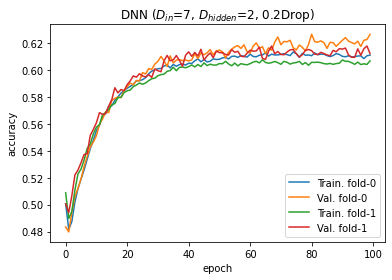

In [ ]:
#plot accuracy
for x in range(0,2):
    plt.plot(fit_history_func[x].history['categorical_accuracy'], label='Train. fold-'+str(x))
    plt.plot(fit_history_func[x].history['val_categorical_accuracy'], label='Val. fold-'+str(x))
    plt.title('DNN ($D_{in}$=7, $D_{hidden}$=2, 0.2Drop)')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(loc='lower right')

saveit = "{}/{}".format(path_tosave, "dnn_accepo.png") 
plt.savefig(saveit)
plt.show()

In [ ]:
#save the training for even
output_dir = path_tosave
file_name = "2hdm"
job_suff = "_{}".format(file_name)
arch_name = "architecture_cift{}.json".format(job_suff)
weights_name = "weights_cift{}.h5".format(job_suff)

mkdir_p(output_dir)
arch_name = "{}/{}".format(output_dir, arch_name)
weights_name = "{}/{}".format(output_dir, weights_name)

print("Saving architecture to: {}".format(os.path.abspath(arch_name)))
print("Saving weights to     : {}".format(os.path.abspath(weights_name)))
with open(arch_name, 'w') as arch_file :
    arch_file.write(my_model_fin_func[0].to_json())
my_model_fin_func[0].save_weights(weights_name)

Saving architecture to: /content/gdrive/MyDrive/vll_2LOS_cat3_lessvariable2methtjetsmtlep/architecture_cift_2hdm.json
Saving weights to     : /content/gdrive/MyDrive/vll_2LOS_cat3_lessvariable2methtjetsmtlep/weights_cift_2hdm.h5


In [ ]:
#save the training for odd
output_dir = path_tosave
file_name = "2hdm"
job_suff = "_{}".format(file_name)
arch_name = "architecture_tek{}.json".format(job_suff)
weights_name = "weights_tek{}.h5".format(job_suff)

mkdir_p(output_dir)
arch_name = "{}/{}".format(output_dir, arch_name)
weights_name = "{}/{}".format(output_dir, weights_name)

print("Saving architecture to: {}".format(os.path.abspath(arch_name)))
print("Saving weights to     : {}".format(os.path.abspath(weights_name)))
with open(arch_name, 'w') as arch_file :
    arch_file.write(my_model_fin_func[1].to_json())
my_model_fin_func[1].save_weights(weights_name)

Saving architecture to: /content/gdrive/MyDrive/vll_2LOS_cat3_lessvariable2methtjetsmtlep/architecture_tek_2hdm.json
Saving weights to     : /content/gdrive/MyDrive/vll_2LOS_cat3_lessvariable2methtjetsmtlep/weights_tek_2hdm.h5


In [ ]:
#load the model
def load_model(arch_path, weights_path) :
    #arch_name = "/home/jovyan/test2/architecture_test2.json"
    #weights_name = "/home/jovyan/test2/weights_test2.h5"
    print(os.path.abspath(arch_path))
    print("Loading model architecture and weights (%, %)".format(os.path.abspath(arch_path), os.path.abspath(weights_path)))
    from tensorflow.keras.models import model_from_json
    json_file = open(os.path.abspath(arch_path), 'r')
    loaded_model = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model)
    loaded_model.load_weights(os.path.abspath(weights_path))
    return loaded_model

In [ ]:
#load the even model
arch_path = "{}/architecture_cift_2hdm.json".format(path_tosave)
weights_path = "{}/weights_cift_2hdm.h5".format(path_tosave)
my_model_loaded_cift = load_model(arch_path, weights_path)

/content/gdrive/MyDrive/vll_2LOS_cat3_lessvariable2methtjetsmtlep/architecture_cift_2hdm.json
Loading model architecture and weights (%, %)


In [ ]:
#load the odd model
arch_path = "{}/architecture_tek_2hdm.json".format(path_tosave)
weights_path = "{}/weights_tek_2hdm.h5".format(path_tosave)
my_model_loaded_tek = load_model(arch_path, weights_path)

/content/gdrive/MyDrive/vll_2LOS_cat3_lessvariable2methtjetsmtlep/architecture_tek_2hdm.json
Loading model architecture and weights (%, %)


5960/5960 [==============================] - 5s 824us/step
[0.70893961 0.2275179  0.68039048 ... 0.32271549 0.35543424 0.06138942]
[0.52945405 0.74895275 0.49606958 ... 0.25235799 0.22144151 0.40251288]
[0.13938127 0.44707945 0.04740565 ... 0.06147441 0.07168212 0.75230289]
[0.23389491 0.62276477 0.29755387 ... 0.61109596 0.59347725 0.2215893 ]
[0.43361208 0.22620301 0.46049857 ... 0.37735274 0.3219851  0.54126024]
[0.39290443 0.49265662 0.21510912 ... 0.21557327 0.21350604 0.16665931]
[0.05716548 0.14971726 0.02205561 ... 0.06618849 0.05108846 0.71702123]
[0.03693378 0.02484416 0.04343187 ... 0.37028927 0.45657343 0.05622685]
[0.46771434 0.06026391 0.73748517 ... 0.72295231 0.7148118  0.08103784]


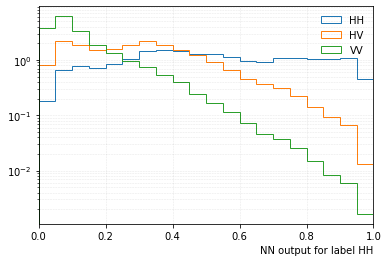

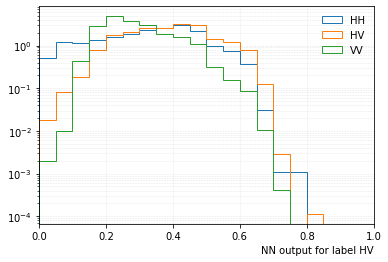

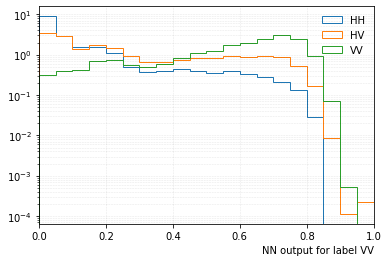

In [ ]:
#evaluate the model
nn_scores_2 = make_nn_output_plots_tekcift( path_tosave, [my_model_loaded_cift,my_model_loaded_tek], inputs = inp_nonsc, samples = training_samples,  targets = targets, events=evtnum)

In [ ]:
#Confusion matrix
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    bottom, top = plt.ylim()
    #plt.ylim(bottom + 0.5, top - 0.5)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
            
    savename = "conf_mat_tr.pdf"

    savename = "{}/{}".format(path_tosave, savename) 
    plt.savefig(savename, bbox_inches = 'tight', dpi = 200)

In [ ]:
mass = np.where(mass==501713., 200, mass)
mass = np.where(mass==501714., 600, mass)
mass = np.where(mass==501715., 1000, mass)
# mass = np.where(mass==312443., 700, mass)
# mass = np.where(mass==312444., 800, mass)
# mass = np.where(mass==312445., 900, mass)
# mass = np.where(mass==312446., 1000, mass)
# mass = np.where(mass==501816., 300, mass)
# mass = np.where(mass==501817., 400, mass)
# mass = np.where(mass==501818., 500, mass)
# mass = np.where(mass==501819., 600, mass)
# mass = np.where(mass==501809., 400, mass)
# mass = np.where(mass==501810., 500, mass)
# mass = np.where(mass==501811., 600, mass)
# mass = np.where(mass==501820., 400, mass)
# mass = np.where(mass==501821., 500, mass)
# mass = np.where(mass==501822., 600, mass)
# mass = np.where(mass==501805., 300, mass)
# mass = np.where(mass==501806., 400, mass)
# mass = np.where(mass==501807., 500, mass)
# mass = np.where(mass==501808., 600, mass)
# mass = np.where(mass==501812., 300, mass)
# mass = np.where(mass==501813., 400, mass)
# mass = np.where(mass==501814., 500, mass)
# mass = np.where(mass==501815., 600, mass)
# mass = np.where(mass==501801., 300, mass)
# mass = np.where(mass==501802., 400, mass)
# mass = np.where(mass==501803., 500, mass)
# mass = np.where(mass==501804., 600, mass)

In [ ]:
cnf_matrix = confusion_matrix(targets, nn_scores_2_cls)
np.set_printoptions(precision=4)

In [ ]:
cnf_matrix

array([[ 10779,   5203,   2453],
       [ 41313,  74611,  60537],
       [  8792,  31391, 154713]])

Normalized confusion matrix
[[0.5774 0.2889 0.1337]
 [0.2256 0.431  0.3434]
 [0.0452 0.1606 0.7943]]


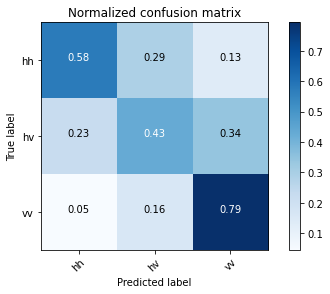

In [ ]:

plot_confusion_matrix(cnf_matrix, classes=['hh','hv','vv'],
                      normalize=True,
                      title='Normalized confusion matrix')
#'sstt','ttq','ttt','tttq','tttt'
#classes=['hh','hz','wh','ww','wz','zz']